In [46]:
from dateutil import tz
from matplotlib.ticker import FuncFormatter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [47]:
def parse_y(y, pos):
    return '%1.0fG' % (y)

In [48]:
df = pd.read_csv('clean/reporte_consolidado.csv', index_col=0)

In [49]:
df["Fecha"] = pd.to_datetime(df["Fecha"], format="%Y-%m-%d %H:%M:%S", exact=True)

In [50]:
df.head()

,Fecha,Ciudad,Tipo_Enlace,Traffic
0,2020-09-01,Alausi,B,0.00
1,2020-09-01,Alausi,P,0.32
2,2020-09-01,Ambato,B,7.49
3,2020-09-01,Ambato,P,5.86
4,2020-09-01,Atuntaqui,B,1.06


## Visualizacion de evolución de todo el tráfico

In [51]:
total = df.groupby("Fecha").sum().reset_index()
total.head()

,Fecha,Traffic
0,2019-04-01 00:00:00,325.73
1,2019-04-01 02:00:00,150.55
2,2019-04-01 04:00:00,75.77
3,2019-04-01 06:00:00,141.11
4,2019-04-01 08:00:00,204.81


In [55]:
monthly = total.groupby(pd.Grouper(key='Fecha',freq='MS')).max().reset_index()
monthly.columns = ["Fecha","Max"]
monthly["PC95"] = total.groupby(pd.Grouper(key='Fecha',freq='MS')).quantile(0.95).reset_index()["Traffic"]
monthly = pd.melt(monthly,id_vars=["Fecha"],var_name="Tipo",value_name="Traffic")
monthly.head()

,Fecha,Tipo,Traffic
0,2019-04-01,Max,457.83
1,2019-05-01,Max,570.19
2,2019-06-01,Max,594.23
3,2019-07-01,Max,600.40
4,2019-08-01,Max,655.90


In [53]:
sns.set_style('darkgrid')

Text(0.5, 1.0, 'Evolución del tráfico a escala Nacional - Últimos 18 meses')

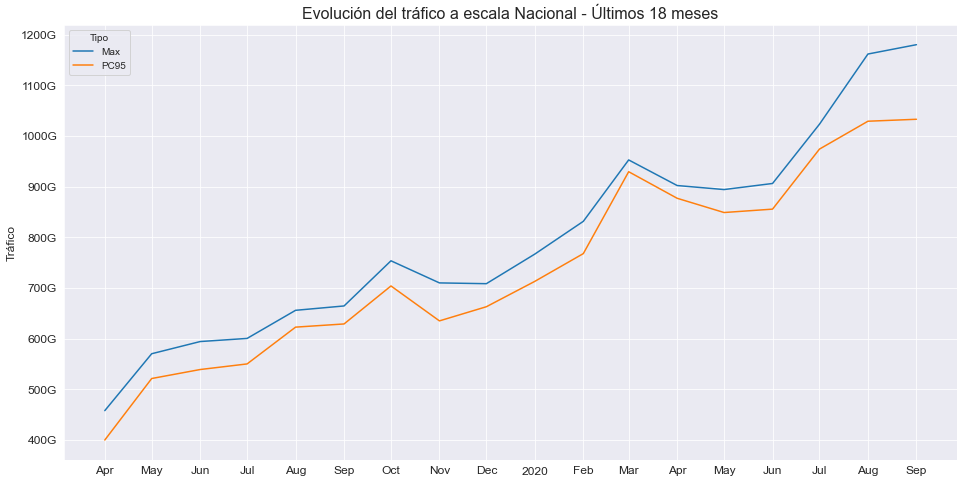

In [54]:
fig,ax = plt.subplots(figsize=(16,8))
_ = sns.lineplot(data=monthly, x="Fecha", y="Traffic", ax=ax, markers=True,hue="Tipo")
formatter = FuncFormatter(parse_y)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))


ax.tick_params(axis='both', which='minor', labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel("")
ax.set_ylabel("Tráfico", fontsize=12)
plt.grid(b=True,which='both',axis='both')
ax.set_title("Evolución del tráfico a escala Nacional - Últimos 18 meses",fontsize=16)


## Visualización de tráfico por tipo Principal/Backup

In [56]:
xtipo = df.groupby(["Fecha","Tipo_Enlace"]).sum().reset_index()

In [57]:
xtipo.head()

,Fecha,Tipo_Enlace,Traffic
0,2019-04-01 00:00:00,B,41.30
1,2019-04-01 00:00:00,P,284.43
2,2019-04-01 02:00:00,B,19.94
3,2019-04-01 02:00:00,P,130.61
4,2019-04-01 04:00:00,B,9.81


In [58]:
xtipo_monthly = xtipo.groupby([pd.Grouper(key='Fecha',freq='MS'),"Tipo_Enlace"]).max().reset_index()
xtipo_monthly.columns = ["Fecha","Tipo_Enlace","Max"]
xtipo_monthly["PC95"] = xtipo.groupby([pd.Grouper(key='Fecha',freq='MS'),"Tipo_Enlace"]).quantile(0.95).reset_index()["Traffic"]
xtipo_monthly = pd.melt(xtipo_monthly,id_vars=["Fecha","Tipo_Enlace"],var_name="Tipo",value_name="Traffic")
xtipo_monthly

,Fecha,Tipo_Enlace,Tipo,Traffic
0,2019-04-01,B,Max,48.8000
1,2019-04-01,P,Max,410.3800
2,2019-05-01,B,Max,49.6100
3,2019-05-01,P,Max,520.5800
4,2019-06-01,B,Max,56.5600
...,...,...,...,...
67,2020-07-01,P,PC95,888.2920
68,2020-08-01,B,PC95,88.4105
69,2020-08-01,P,PC95,945.5790
70,2020-09-01,B,PC95,110.8290


Text(0.5, 1.0, 'Evolución del tráfico por tipo de enlace - Últimos 18 meses')

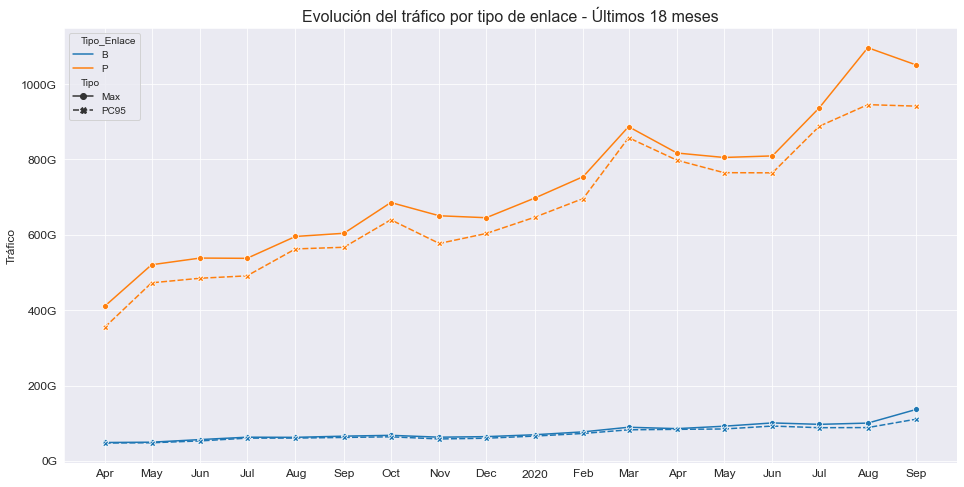

In [59]:
fig,ax = plt.subplots(figsize=(16,8))
_ = sns.lineplot(data=xtipo_monthly, x="Fecha", y="Traffic", ax=ax, markers=True, hue="Tipo_Enlace",style="Tipo")

formatter = FuncFormatter(parse_y)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

ax.tick_params(axis='both', which='minor', labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel("")
ax.set_ylabel("Tráfico", fontsize=12)
plt.grid(b=True,which='both',axis='both')
ax.set_title("Evolución del tráfico por tipo de enlace - Últimos 18 meses",fontsize=16)


## Visualización de todo el tráfico dia vs noche (Usando percentil 95th)

In [60]:
df.head()

,Fecha,Ciudad,Tipo_Enlace,Traffic
0,2020-09-01,Alausi,B,0.00
1,2020-09-01,Alausi,P,0.32
2,2020-09-01,Ambato,B,7.49
3,2020-09-01,Ambato,P,5.86
4,2020-09-01,Atuntaqui,B,1.06


In [61]:
def parse_date(row):
    #print(row.hour)
    if row.hour >= 18 or (row.hour >= 0 and row.hour <= 2):
        return "Noche"
    elif row.hour > 14:
        return "Tarde"
    elif row.hour >= 6 and row.hour <=14:
        return "Dia"
    elif row.hour > 2:
        return "Madrugada"

In [62]:
df['Horario'] = df['Fecha'].apply(parse_date)

In [63]:
df.head()

,Fecha,Ciudad,Tipo_Enlace,Traffic,Horario
0,2020-09-01,Alausi,B,0.00,Noche
1,2020-09-01,Alausi,P,0.32,Noche
2,2020-09-01,Ambato,B,7.49,Noche
3,2020-09-01,Ambato,P,5.86,Noche
4,2020-09-01,Atuntaqui,B,1.06,Noche


In [64]:
xhorario = df.groupby(["Fecha","Horario"]).sum().reset_index()
xhorario[xhorario['Fecha']>="2020-09-29"].head(12)

,Fecha,Horario,Traffic
6564,2020-09-29 00:00:00,Noche,693.05
6565,2020-09-29 02:00:00,Noche,299.76
6566,2020-09-29 04:00:00,Madrugada,195.77
6567,2020-09-29 06:00:00,Dia,582.33
6568,2020-09-29 08:00:00,Dia,776.33
6569,2020-09-29 10:00:00,Dia,833.54
6570,2020-09-29 12:00:00,Dia,856.20
6571,2020-09-29 14:00:00,Dia,934.42
6572,2020-09-29 16:00:00,Tarde,961.17
6573,2020-09-29 18:00:00,Noche,1010.67


In [65]:
xhorario_monthly = xhorario.groupby([pd.Grouper(key='Fecha',freq='MS'),"Horario"]).quantile(0.95).reset_index()
xhorario_monthly = xhorario_monthly[(xhorario_monthly['Horario'] == "Dia") | (xhorario_monthly['Horario'] == "Noche")]

Text(0.5, 1.0, 'Evolución del tráfico por franja horaria - Últimos 18 meses')

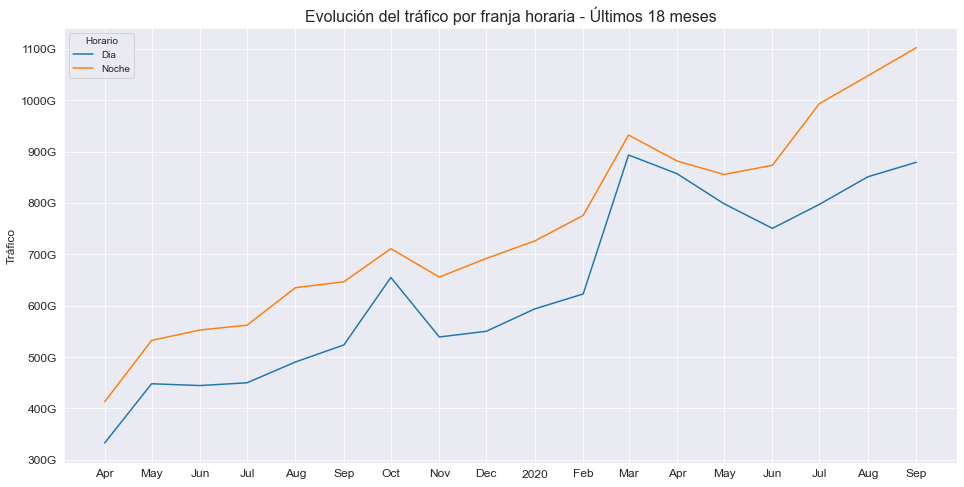

In [66]:
fig,ax = plt.subplots(figsize=(16,8))
_ = sns.lineplot(data=xhorario_monthly, x="Fecha", y="Traffic", ax=ax, markers=True, hue="Horario")

formatter = FuncFormatter(parse_y)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

ax.tick_params(axis='both', which='minor', labelsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel("")
ax.set_ylabel("Tráfico", fontsize=12)
plt.grid(b=True,which='both',axis='both')
ax.set_title("Evolución del tráfico por franja horaria - Últimos 18 meses",fontsize=16)

## Visualización por ciudades donde se ha hecho mayor uso de Backups

In [67]:
backups = df[df['Tipo_Enlace']=='B']
backups

,Fecha,Ciudad,Tipo_Enlace,Traffic,Horario
0,2020-09-01 00:00:00,Alausi,B,0.00,Noche
2,2020-09-01 00:00:00,Ambato,B,7.49,Noche
4,2020-09-01 00:00:00,Atuntaqui,B,1.06,Noche
6,2020-09-01 00:00:00,Babahoyo,B,1.87,Noche
8,2020-09-01 00:00:00,Balsas,B,0.00,Noche
...,...,...,...,...,...
34184,2019-04-30 22:00:00,Tena,B,0.29,Noche
34186,2019-04-30 22:00:00,Tonsupa,B,0.15,Noche
34188,2019-04-30 22:00:00,Tulcan,B,0.24,Noche
34196,2019-04-30 22:00:00,Vinces,B,0.40,Noche


In [68]:
backups_x_ciudad = backups.groupby(['Ciudad',pd.Grouper(key='Fecha',freq='M')]).quantile(0.95).reset_index()
backups_x_ciudad

,Ciudad,Fecha,Traffic
0,Alausi,2020-06-30,0.0000
1,Alausi,2020-07-31,0.0000
2,Alausi,2020-08-31,0.0000
3,Alausi,2020-09-30,0.0000
4,Ambato,2019-04-30,2.6815
...,...,...,...
877,Zaruma,2020-05-31,0.0000
878,Zaruma,2020-06-30,0.0000
879,Zaruma,2020-07-31,0.0000
880,Zaruma,2020-08-31,0.0000


In [69]:
# Pivotear las fechas a columnas
heat_backup = backups_x_ciudad.pivot(index="Ciudad",columns=["Fecha"],values="Traffic").reset_index()
heat_backup = heat_backup.iloc[:,0:]
heat_backup = heat_backup.fillna(0)
# Ordeno y obtengo el top 15 de Ciudades
heat_backup["Max"] = heat_backup.max(axis=1)
heat_backup = heat_backup.sort_values("Max",ascending=False)
heat_backup = heat_backup.iloc[:15,:]
heat_backup = heat_backup.set_index('Ciudad')
heat_backup.columns = ["Abr 2019","May 2019","Jun 2019","Jul 2019","Ago 2019","Sep 2019","Oct 2019","Nov 2019","Dic 2019","Ene 2020","Feb 2020","Mar 2020","Abr 2020","May 2020","Jun 2020","Jul 2020","Ago 2020","Sep 2020","Max"]
heat_backup.drop(columns=["Max"], inplace=True)
heat_backup

,Abr 2019,May 2019,Jun 2019,Jul 2019,Ago 2019,Sep 2019,Oct 2019,Nov 2019,Dic 2019,Ene 2020,Feb 2020,Mar 2020,Abr 2020,May 2020,Jun 2020,Jul 2020,Ago 2020,Sep 2020
Ciudad,,,,,,,,,,,,,,,,,,
Riobamba,5.5600,5.8300,6.3800,6.5045,5.7135,5.5610,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,7.9605,7.9400,7.9600,11.3125
Manta,4.7810,4.9600,5.3505,5.7925,5.8080,6.0210,6.4490,5.5000,5.6000,6.8845,7.7465,7.9800,7.9900,7.9900,7.9800,7.9900,7.9600,10.1610
Salinas,5.3900,5.0645,4.9705,6.0400,6.2000,6.6900,6.5000,6.0005,5.5990,6.5000,7.0830,7.9900,7.9700,7.6815,7.9110,7.9800,7.9900,8.2945
Ambato,2.6815,2.7245,2.9400,3.0900,3.3100,3.4910,4.3500,3.5705,3.8600,4.0690,4.2600,6.6200,6.7500,6.8045,7.2325,7.9600,7.9600,8.1845
Portoviejo,4.7100,4.8200,5.2600,6.1800,6.6545,7.0510,7.6135,7.7015,6.6300,6.8400,7.7860,7.9845,7.0500,7.2545,7.2710,6.8400,6.0425,6.7905
Qvdo,2.7800,2.7900,3.5400,3.7500,3.8900,4.0100,4.3500,4.0005,4.1945,5.0200,6.0200,6.9345,7.7705,7.5015,7.0900,7.8100,7.9800,7.9805
Ibarra,3.0505,3.0945,3.2400,3.5900,3.5100,3.5125,4.0300,3.8300,4.3550,4.9200,6.2685,6.7945,6.4035,6.7900,6.5100,7.5790,7.9745,7.8900
Cuenca,1.8610,1.7990,1.9005,2.4790,2.5200,2.7305,3.1300,2.7730,3.0145,3.5390,3.9100,5.0490,5.0305,5.2500,5.5200,6.3700,7.0390,7.8500
Stodomingo,2.7000,2.5300,2.7705,2.9545,3.2245,3.2805,3.6135,3.3500,3.6545,3.8400,4.1700,5.0590,4.7400,4.8800,5.1005,5.0645,5.2600,7.6415


Text(0.5, 1.0, 'Tráfico promedio de enlaces backup por ciudades - Últimos 18 meses')

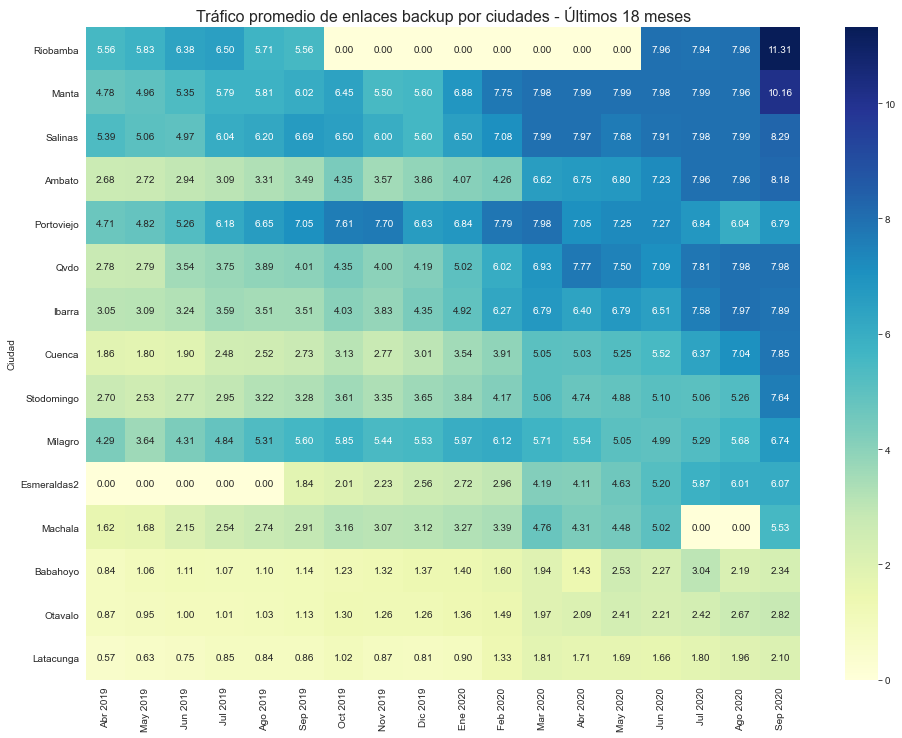

In [70]:
fig,ax = plt.subplots(figsize=(16,12))
_ = sns.heatmap(heat_backup, ax=ax, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_title("Tráfico promedio de enlaces backup por ciudades - Últimos 18 meses",fontsize=16)

## Ciudades que mas consumen (Principal y Backup)

In [71]:
# Sumar principales y backup
ciudades = df[['Ciudad','Fecha','Tipo_Enlace','Traffic']].groupby(['Ciudad','Fecha']).sum().reset_index()
# Promedia el mes
ciudades = ciudades.groupby(['Ciudad',pd.Grouper(key="Fecha",freq="M")]).quantile(0.95).reset_index()
ciudades = ciudades.sort_values("Traffic",ascending=False)
ciudades["Ciudad"] = ciudades['Ciudad'].str.replace("Gyes","GYE Sur").str.replace("Gyei","GYE Inmaconsa").str.replace("Gyea","GYE Aurora").str.replace("Gyem","GYE Miraflores").str.replace("Gyek","GYE Kennedy").str.replace("Gyec","GYE Centro")
ciudades["Ciudad"] = ciudades["Ciudad"].str.replace("Uios","UIO Sur").str.replace("Uiod","UIO Datacenter").str.replace("Uiog","UIO Gosseal").str.replace("Uioa","UIO Armenia").str.replace("Uiob","UIO Borromoni").str.replace("Uiom","UIO Muros")

In [72]:
# Top de ciudades en Marzo 2020
ciudades_marzo = ciudades[ciudades['Fecha']=='2020-03-31']
ciudades_marzo = ciudades_marzo.iloc[:15,:]
ciudades_marzo
# Top de ciudades en Octubre 2019
ciudades_oct = ciudades[ciudades['Fecha']=='2019-10-31']
ciudades_oct = ciudades_oct.iloc[:15,:]
ciudades_oct

,Ciudad,Fecha,Traffic
379,GYE Sur,2019-10-31,104.6385
1061,UIO Sur,2019-10-31,82.7935
325,GYE Inmaconsa,2019-10-31,76.3220
1007,UIO Datacenter,2019-10-31,69.8325
289,GYE Aurora,2019-10-31,50.0435
1025,UIO Gosseal,2019-10-31,44.7895
971,UIO Armenia,2019-10-31,31.9035
361,GYE Miraflores,2019-10-31,26.9000
989,UIO Borromoni,2019-10-31,26.5100
343,GYE Kennedy,2019-10-31,21.8525


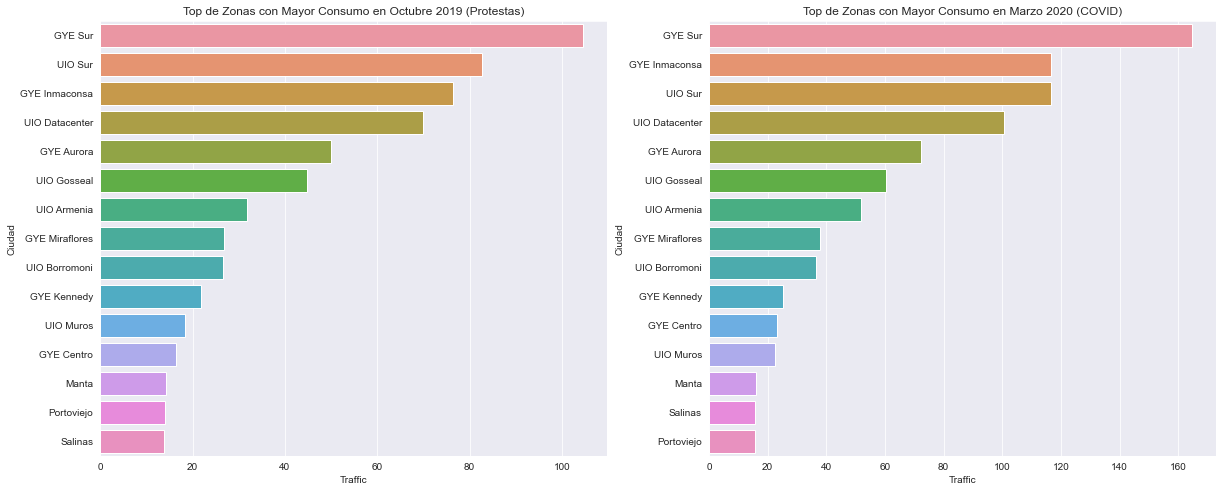

In [73]:
fig,ax = plt.subplots(1,2,figsize=(20,8))
sns.barplot(data=ciudades_marzo,y='Ciudad',x='Traffic',orient='h', ax=ax[1])
sns.barplot(data=ciudades_oct,y='Ciudad',x='Traffic',orient='h', ax=ax[0])
_ = ax[1].set_title("Top de Zonas con Mayor Consumo en Marzo 2020 (COVID)")
_ = ax[0].set_title("Top de Zonas con Mayor Consumo en Octubre 2019 (Protestas)")

In [74]:
# TODO crear nueva variable categorica de region y comparar